In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [22]:
class FacetDataset(Dataset):
    """Facet dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.attributes_frame = pd.read_csv(csv_file)
        self.root_dir = list(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.attributes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        for i in self.root_dir:   
            img_name = os.path.join(i,
                                    self.attributes_frame.iloc[idx, 2])
            image = io.imread(img_name)
            attributes = self.attributes_frame.iloc[idx, 3:]
            attributes = np.array([attributes]).reshape(-1, 1)
            sample = {'image': image, 'attributes': attributes}

            if self.transform:
                sample = self.transform(sample)

            return sample

0 (1500, 2000, 3) (50, 1)


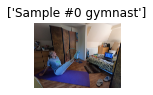

FileNotFoundError: No such file: '/Users/landon/Desktop/Capstone/FACET/imgs_1/sa_10930017.jpg'

In [25]:
face_dataset = FacetDataset(csv_file='annotations/annotations.csv',
                                    root_dir=['imgs_1', 'imgs_2', 'imgs_3'])

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['attributes'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(sample['image'])
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i) + ' ' + sample['attributes'][0])
    ax.axis('off')
    plt.show()
    if i == 3:
        break